# Image Captioning using Deep Learning: Assignment-3

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
from sklearn.model_selection import train_test_split
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [249]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#     # Set a fixed value for the hash seed
#     os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [250]:
import torchvision
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_path = './'

train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Your Code from here...

In [251]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train, [45000,5000])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1)

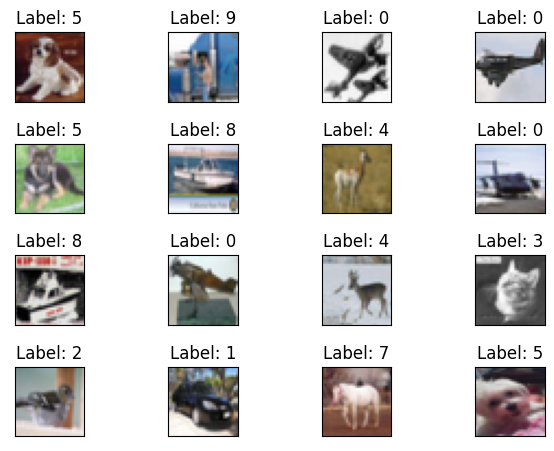

In [252]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
fig = plt.figure()
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  j=int((np.random.rand()*1000)%1000)
  plt.imshow(train.data[j])
  plt.title("Label: {}".format(train.targets[j]))
  plt.xticks([])
  plt.yticks([])


## Creating a Dataset Class


In [253]:
# define your dataset class
nn = torch.nn
F = nn.functional
optim= torch.optim
process_data=[]
process_cross=[]
# for i in X_train:
#     process_data.append((torch.from_numpy((np.transpose(i, (2, 0, 1)))).to(torch.float)))
# for i in X_test:
#     process_cross.append(torch.from_numpy((np.transpose(i, (2, 0, 1)))).to(torch.float))

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [254]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class Net(nn.Module):
    def __init__(self): 
          super(Net, self).__init__()
          self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,padding=2)   
          self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,padding=2)
          self.maxpool = nn.MaxPool2d(2,stride=2)
          self.fc1 = nn.Linear(16*8*8, 120, bias=True)
          self.fc2 = nn.Linear(120,84, bias=True)
          self.fc3 = nn.Linear(84,10, bias=True)
          self.relu = nn.ReLU()
          self.bn1 = nn.BatchNorm1d(120)
          self.bn2 = nn.BatchNorm1d(84)
          self.softmx = nn.Softmax(dim=-1)
          
    def forward(self,x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.bn1(self.fc1(x)))      
        x = self.relu(self.bn2(self.fc2(x)))  
        x = self.softmx(self.fc3(x))
        return x



## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [255]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model((data))
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [256]:
def predict(model, X_test):
    yhats = []
    for i in range(X_test.shape[0]):
        a = X_test[i]
        # make prediction
        yhat = model(a)
        # retrieve numpy array
        yhat = yhat.data.max(0,keepdim=True)
        yhats.append(int(yhat.indices))
    return yhats

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [257]:
def accuracy(pred, labels):
    count = 0
    Correct_preds = []
    for a in range(len(pred)):
        if pred[a] == labels[a]:
            Correct_preds.append(pred[a])
            count+=1
    return count/len(pred), Correct_preds

In [258]:
network = Net()
learning_rate = 0.001
momentum = 0.5
n_epochs=15
optimizer = optim.Adam(network.parameters())
criterian =  F.nll_loss
for i in range(n_epochs):
   train(network,optimizer,criterian,train_loader)

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [263]:
val_loader = DataLoader(test, batch_size=64)
predictions = []
actuals = []
actual2 = []
for batch_idx, (data, target) in enumerate(val_loader):
    predictions.append((torch.detach((network(data))).numpy()))
    actuals += (list(torch.detach((target)).numpy()))
for i in predictions:
    for j in i:
        actual2.append(int(j.argmax()))
predictions=actual2.copy()
acuuracy_and_array = accuracy(actual2,actuals)
import pandas as pd
df = {'predictions': [], 'y_test': [], 'correct_pred': []}
for i in range(0,10):
    df['predictions'].append(predictions.count(i))
    df['y_test'].append(list(actuals).count(i))
    df['correct_pred'].append(acuuracy_and_array[1].count(i))
df = pd.DataFrame(df)
print(df)
print("The overall Acuuracy of the Model is:" , accuracy(predictions, actuals)[0])
# acc=accuracy(b,y_test)
# print(f"Avg accuracy score is {acc[0]}")
# y=roc_auc_score_multiclass(y_test,b)

   predictions  y_test  correct_pred
0         1063    1000           706
1         1004    1000           777
2          839    1000           490
3         1030    1000           479
4         1010    1000           578
5          886    1000           513
6         1127    1000           751
7         1046    1000           722
8         1036    1000           789
9          959    1000           677
The overall Acuuracy of the Model is: 0.6482


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_3.pt``` model-weights file to the repository.

In [260]:
from google.colab import files
torch.save(final_model, 'ass_3.pt')
files.download('ass_3.pt') # download the file from the Colab session for submission

ModuleNotFoundError: No module named 'google.colab'

Check if it got saved right!

In [264]:
# load the model, use predict function# define a child class of nn.Module for your model
# specify the architecture here itself
torch.save(network, 'ass_3.pt')
a = torch.load('ass_3.pt')
val_loader = DataLoader(val_ds, batch_size=64)
predictions = []
actuals = []
actual2 = []
for batch_idx, (data, target) in enumerate(val_loader):
    predictions.append((torch.detach((a(data))).numpy()))
    actuals += (list(torch.detach((target)).numpy()))
for i in predictions:
    for j in i:
        actual2.append(int(j.argmax()))
predictions=actual2.copy()
acuuracy_and_array = accuracy(actual2,actuals)
import pandas as pd
df = {'predictions': [], 'y_test': [], 'correct_pred': []}
for i in range(0,10):
    df['predictions'].append(predictions.count(i))
    df['y_test'].append(list(actuals).count(i))
    df['correct_pred'].append(acuuracy_and_array[1].count(i))
df = pd.DataFrame(df)
print(df)
print("The overall Acuuracy of the Model is:" , accuracy(predictions, actuals)[0])

   predictions  y_test  correct_pred
0          507     488           350
1          502     512           391
2          440     532           281
3          545     471           227
4          478     471           279
5          422     514           243
6          557     507           378
7          528     500           365
8          529     504           403
9          492     501           347
The overall Acuuracy of the Model is: 0.6528
